# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, STANDARD_REACH, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', '../we.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2          freq
0        ¶м   192  ¶  м  -  c  1.593387e-04
1        мо  4262  м  о  c  v  3.536988e-03
2        ож  2339  о  ж  v  c  1.941111e-03
3        же  3944  ж  е  c  v  3.273083e-03
4        ет  6628  е  т  v  c  5.500506e-03
...     ...   ... .. .. .. ..           ...
2660     юв     1  ю  в  v  c  8.298893e-07
2661     ч;     1  ч  ;  c  -  8.298893e-07
2662     ц¶     1  ц  ¶  c  -  8.298893e-07
2663     у2     1  у  2  v  -  8.298893e-07
2664     ц?     1  ц  ?  c  -  8.298893e-07

[2665 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   93113
е   78090
а   70594
и   55193
т   54232
н   45844
р   37937
л   37899
с   33225
в   24457
к   23285
м   22199
у   21934
д   20689
ы   18941
ь   17795
я   16759
й   11203
г   11174
з   11088
ч    9504
б    9040
ж    7572
п    7472
х    7434
ю    6163
ш    6118
щ    3197
ц    3187
ё    1222
ф    1141
э     343
ъ     300

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.456472    0.000000  -2.456472    2.456472 -10000.000000
ы  19.353018    0.024897 -19.328122   19.377915  -9974.304069
ь  10.049959    0.016598 -10.033362   10.066557  -9967.023908
а  54.258162    5.834122 -48.424040   60.092284  -8058.279243
о  44.199904    8.630849 -35.569055   52.830752  -6732.642161
у  14.896513    4.755266 -10.141247   19.651778  -5160.472973
и  61.967833   23.427775 -38.540059   85.395608  -4513.119534
е  22.290826  100.466398  78.175571  122.757224   6368.307193
я   5.037428   51.801690  46.764262   56.839118   8227.478464
э   0.024897    1.643181   1.618284    1.668077   9701.492537
ю   0.406646   36.174874  35.768229   36.581520   9777.676951
ё   0.000000    2.166011   2.166011    2.166011  10000.000000

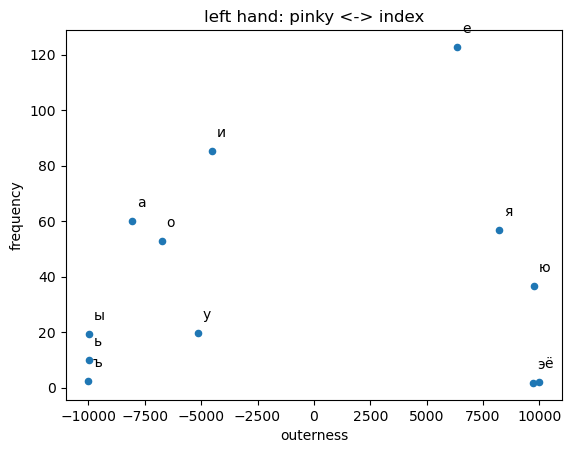

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
ц     1.178443    8.174410   -6.995967    9.352852 -7480.035492
щ     0.722004    4.365218   -3.643214    5.087221 -7161.500816
л    23.386280   85.088549  -61.702269  108.474829 -5688.164639
р    49.494597  159.131272 -109.636674  208.625869 -5255.181193
н    62.216800  165.297349 -103.080549  227.514150 -4530.731351
т    98.059719  175.961427  -77.901708  274.021146 -2842.908628
к    44.988299   72.507428  -27.519129  117.495726 -2342.138720
м    23.909111   21.776295    2.132815   45.685406   466.848320
ф     2.431576    2.149413    0.282162    4.580989   615.942029
в    71.270892   60.540424   10.730469  131.811316   814.077945
ш    13.502299   10.647480    2.854819   24.149778  1182.130584
д    56.067321   39.876181   16.191140   95.943501  1687.570279
х     9.145380    5.717937    3.427443   14.863317  2305.974316
ж    20.556358    7.709672   12.846686   28.266029  4544.920728
с   232.908430   83.063619  149.844811  315.972049  4742.343857
г    31.353217   10.572790   20.780428   41.926007  4956.452890
ч    40.614782   12.962871   27.651911   53.577653  5161.090458
п    74.192103   21.021096   53.171007   95.213199  5584.415584
б    28.755664    5.145314   23.610350   33.900978  6964.504284
з    52.457302    4.780162   47.677140   57.237465  8329.708569
й    19.286627    0.008299   19.278328   19.294926  9991.397849

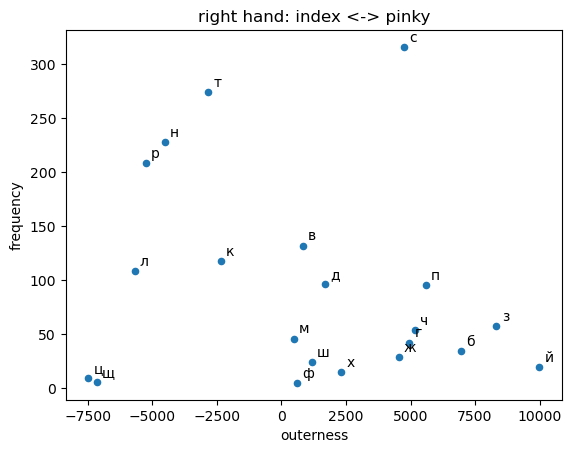

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
753222 6422369
422003 42002368
 10002 2000125
 12213 312213
0
''',
STANDARD_REACH, std_key_shape, STD_EXTRA_KEYS)


# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 0abcd3 6ghij9
 001233 6678
e
''',

'''
9752224 422236
7421134 431123
 210002 200012
 421114 4111
0
''',

'''
9753444 573345
6443224 531134
 211122 221112
 310014 4100
0
'''
, std_key_shape, STD_EXTRA_KEYS)


In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц/
 аиое, йртнсз¶
 щьуяю глдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц/
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фцыёэ шмвкзчх/
 аиое, йртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
 
'тест41': r'''
ъ12345 67890-=
→фцыёэ швкдгжх/
 аоие, лрнтсз¶
 щьуяю ймбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест42': r'''
ъ12345 67890-=
→фыцэё шбвдгжх/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест43': r'''
ъ12345 67890-=
→эыцёх шбвдгжф/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест44': r'''
ъ12345 67890-=
→эьуяю шбдвзжф/
 аиое, млтнсг¶
 щыцхё йркпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
# more balance & slightly better score
'тест45' :r'''
ъ12345 67890-=
→эьуяю цждвзшф/
 аиое, млтнсг¶
 щычхё йркпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 11.0712
key "?" repeated: 2
key """ repeated: 2
layout usphonetic: 7.9279
layout rusdvorak: 5.8056
key ":" repeated: 2
layout диктор: 5.8219
layout зубачёв: 5.5584
key "." repeated: 2
layout скоропис: 5.9629
key """ repeated: 3
key ":" repeated: 2
key ";" repeated: 2
layout ант: 6.1884
layout ugnvs: 6.6721
layout леонов: 4.968
layout леонов2: 4.9238
layout леонов3: 5.1864
layout тест1: 9.8859
layout тест2: 8.6085
layout тест3: 7.2811
layout тест4: 6.6731
layout тест5: 6.2457
layout тест6: 6.0216
layout тест7: 6.297
layout тест8: 6.7013
layout тест9: 6.7396
layout тест10: 6.5365
layout тест11: 6.7001
layout тест12: 6.3011
layout тест13: 6.2918
layout тест14: 6.2164
layout тест15: 5.9414
layout тест16: 5.9518
layout тест17: 5.6897
layout тест18: 5.6483
layout тест19: 5.6958
layout тест20: 5.6894
layout тест21: 5.4728
layout тест22: 5.4728
layout тест23: 5.2528
layout тест24: 4.9906
layout тест25: 5.2448
layout ино1: 4.9213
layout тест26: 4.9775
layout тест27: 4.9402
layout

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест27', ''),
    ('тест43', 'Best with original rules scoring'),
    ('тест44', 'First with the new scoring'),
    ('тест45', 'Currently in use'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   4.273 | Alien #2, many counterparts on AltGr   |
| тест45     |   4.614 | Currently in use                       |
| тест44     |   4.704 | First with the new scoring             |
| ино1       |   4.921 | Alien #1, rare letters on AltGr        |
| тест27     |   4.94  |                                        |
| леонов     |   4.968 | Leonov                                 |
| тест43     |   4.971 | Best with original rules scoring       |
| зубачёв    |   5.558 | Zubachov                               |
| rusdvorak  |   5.806 | Dvorak translit                        |
| диктор     |   5.822 | Dictor                                 |
| скоропис   |   5.963 | Skoropis                               |
| ант        |   6.188 | ANT                                    |
| тест10     |   6.536 | First optimized after ha

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000113 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест46 : 4.612 


/usr/lib/python3/dist-packages/IPython/core/events.py:82: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)


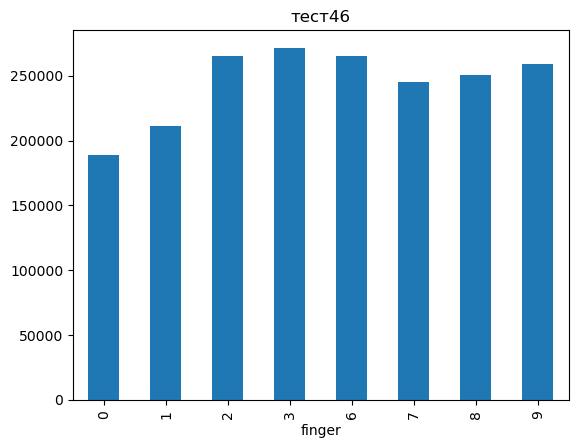

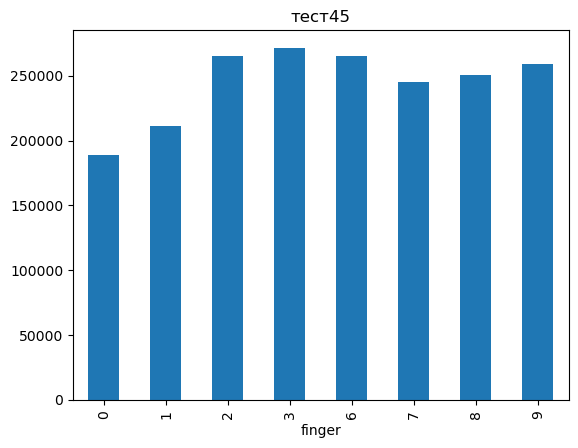

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


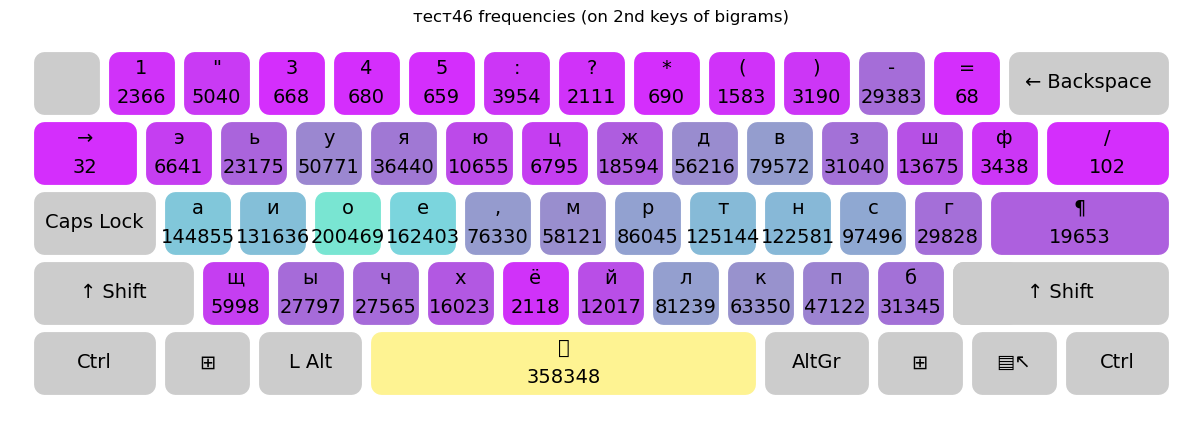

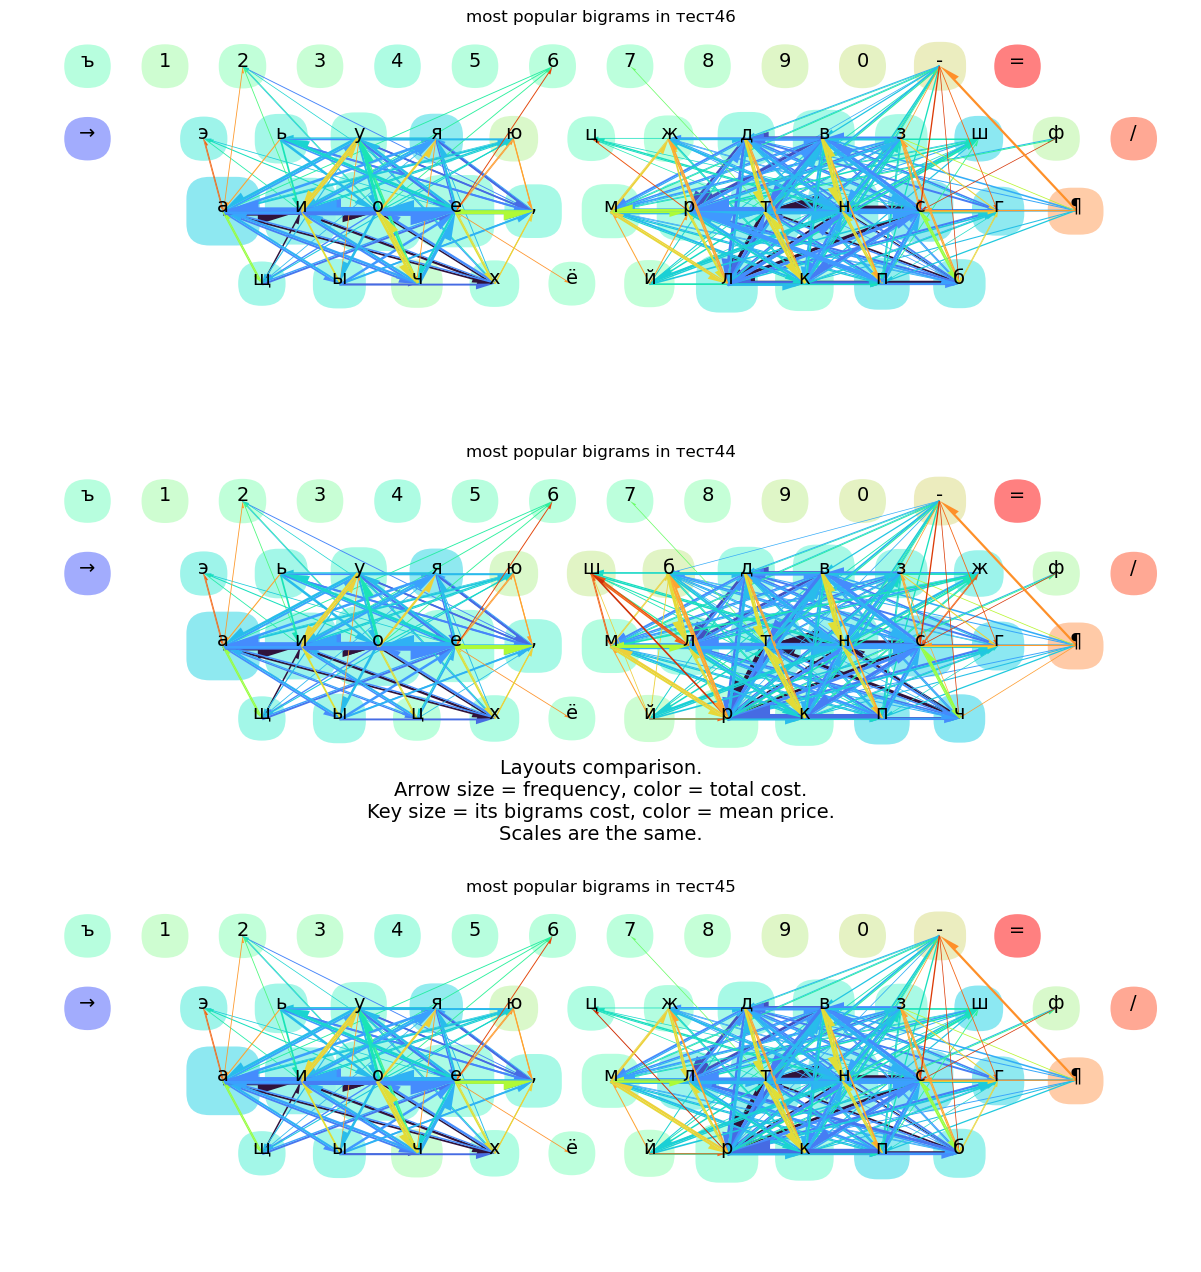

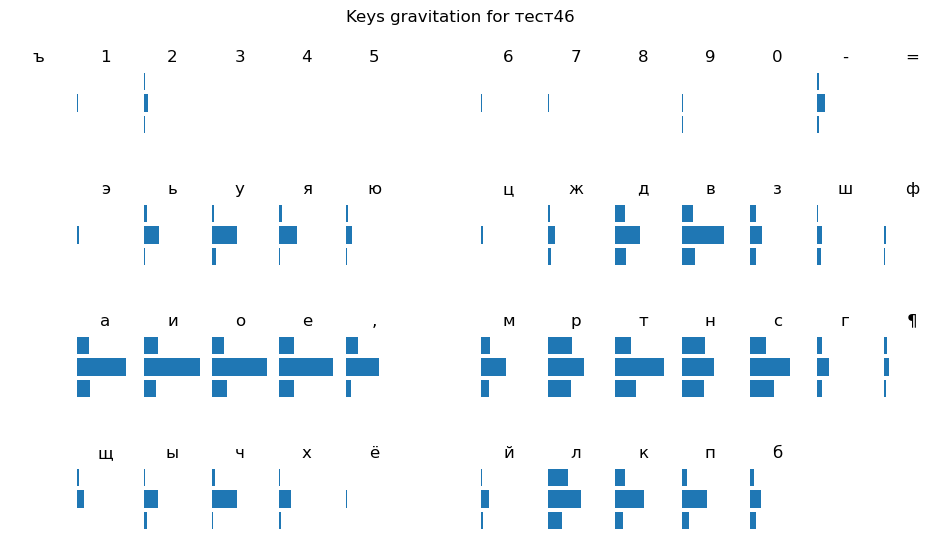

In [13]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

key = 'тест46'
lyt = Layout(key, (r'''
ъ12345 67890-=
→эьуяю цждвзшф/
 аиое, мртнсг¶
 щычхё йлкпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.load_bars()
results['тест45'].load_bars()
r.display('freq')
r.combomap(results['тест44'], results['тест45'])
r.display('rows')


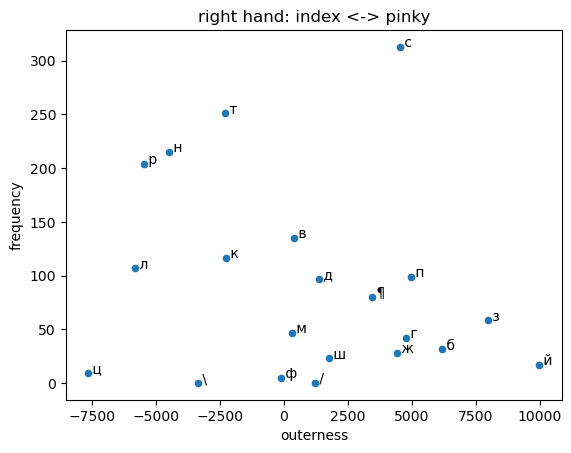

In [14]:
km = r.layout.keyboard.keymap
km = km[(km.hand == 1) & (km.finger != 5) & (km.row > 0)].copy()

d2 = r.bigrams.merge(
    km[['hand', 'finger']], left_on=['row1', 'column1'], right_index=True, suffixes=('', '1')).merge(
    km[['hand', 'finger']], left_on=['row2', 'column2'], right_index=True, suffixes=('', '2'))



t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer',
                                                lsuffix='_out', rsuffix='_in')
t2.fillna(0, inplace=True)
t2['outer'] = (t2.freq_out - t2.freq_in)
t2['frequency'] = t2.freq_in + t2.freq_out
t2['outerness'] = t2.outer / t2.frequency
t2 *= 10000

t3 = r.bigrams.groupby('l1').agg({'freq': 'sum'}).join(r.bigrams.groupby('l2').agg({'freq': 'sum'}), how='outer',
lsuffix='1', rsuffix='2')
t3['freq'] = t3['freq1'] + t3['freq2']
t2['freq'] = t3['freq']

title = 'right hand: index <-> pinky'
ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
for i, row in t2.iterrows():
    ax.annotate(f' {i}', (row.outerness, row.frequency))

In [38]:
b = CORP.bigrams
b[(b.l1 != '⌴') & (b.l2 != '⌴') & ~b.l1.isin(list('аоеиу')) & ~b.l2.isin(list('аиоеу'))].sort_values('num', ascending=False).head(20)

bigram    num l1 l2 t1 t2      freq
48      ст  13250  с  т  c  c  0.010996
41      пр   7127  п  р  c  c  0.005915
38      ть   6899  т  ь  c  v  0.005725
125     --   5731  -  -  -  -  0.004756
46      ль   5330  л  ь  c  v  0.004423
236     ны   5115  н  ы  c  v  0.004245
78      тр   4206  т  р  c  c  0.003491
114     ск   4041  с  к  c  c  0.003354
177     .¶   3922  .  ¶  -  -  0.003255
131     ся   3818  с  я  c  v  0.003169
358     нн   3403  н  н  c  c  0.002824
205     бы   3283  б  ы  c  v  0.002725
183     эт   3125  э  т  v  c  0.002593
53      ¶¶   3004  ¶  ¶  -  -  0.002493
57      сл   2912  с  л  c  c  0.002417
134     чт   2899  ч  т  c  c  0.002406
465     вс   2892  в  с  c  c  0.002400
112     вы   2821  в  ы  c  v  0.002341
49      тв   2554  т  в  c  c  0.002120
610     ..   2335  .  .  -  -  0.001938

In [16]:
r.bigrams[r.bigrams.l2 == 'л'].sort_values('num', ascending=False)

bigram   num l1 l2 t1 t2          freq  num_tri  row1  column1  ...  \
88       ол  8682  о  л  v  c  5.360255e-03     2223     2        3  ...   
45       ел  8226  е  л  v  c  5.303822e-03     1835     2        4  ...   
6        ⌴л  7849  ⌴  л  -  c  2.383442e-03     4977     4        0  ...   
93       ал  7818  а  л  v  c  5.517104e-03     1170     2        1  ...   
24       ил  5351  и  л  v  c  3.525370e-03     1103     2        2  ...   
523      тл  4613  т  л  c  c  1.734469e-04     4404     2        9  ...   
57       сл  4576  с  л  c  c  2.416638e-03     1664     2       11  ...   
340      бл  3937  б  л  c  c  8.556159e-04     2906     3       11  ...   
488      дл  3482  д  л  c  c  6.481435e-04     2701     1        9  ...   
332      вл  3384  в  л  c  c  7.444107e-04     2487     1       10  ...   
250      пл  2855  п  л  c  c  8.813424e-04     1793     3       10  ...   
341      ул  2138  у  л  v  c  1.234875e-03      650     1        3  ...   
225      ыл  2020  ы  л  v  c  1.366828e-03      373     3        2  ...   
479      гл  1947  г  л  c  c  9.469037e-04      806     2       12  ...   
357      кл  1825  к  л  c  c  5.742834e-04     1133     3        9  ...   
1252     нл  1785  н  л  c  c  5.809225e-06     1778     2       10  ...   
765      мл  1770  м  л  c  c  2.273897e-04     1496     2        7  ...   
414      рл  1329  р  л  c  c  8.547860e-05     1226     2        8  ...   
1180     чл  1155  ч  л  c  c  1.244834e-05     1140     3        3  ...   
553      зл  1125  з  л  c  c  1.726170e-04      917     1       11  ...   
1298     жл   992  ж  л  c  c  9.128782e-06      981     1        8  ...   
280      шл   972  ш  л  c  c  3.601720e-04      538     1       12  ...   
97       ял   891  я  л  v  c  4.771863e-04      316     1        4  ...   
518      лл   728  л  л  c  c  2.033229e-04      483     3        8  ...   
648      хл   520  х  л  c  c  1.186742e-04      377     3        4  ...   
1388     ¶л   198  ¶  л  -  c  4.647380e-05      142     2       13  ...   
575      цл   190  ц  л  c  c  8.298893e-07      189     1        7  ...   
1236     йл   150  й  л  c  c  3.319557e-05      110     3        7  ...   
1003     фл   144  ф  л  c  c  3.900480e-05       97     1       13  ...   
317      эл   133  э  л  v  c  9.377749e-05       20     1        1  ...   
922      -л   132  -  л  -  c  5.228303e-05       69     0       12  ...   
1989     .л    93  .  л  -  c  8.298893e-07       92     2        5  ...   
1962     юл    83  ю  л  v  c  1.576790e-05       64     1        5  ...   
552      ёл    62  ё  л  v  c  4.813358e-05        4     3        5  ...   
833      "л    48  "  л  -  c  1.659779e-05       28     0        2  ...   
1248     (л    36  (  л  -  c  6.639114e-06       28     0       10  ...   

      rollout  k2penalty  row column  finger ftype  hand  penalty  reach  \
88          0          0    3      8       6     1     1        0      1   
45          0          0    3      8       6     1     1        0      1   
6           0          0    3      8       6     1     1        0      1   
93          0          0    3      8       6     1     1        0      1   
24          0          0    3      8       6     1     1        0      1   
523         0          0    3      8       6     1     1        0      1   
57          0          0    3      8       6     1     1        0      1   
340         0          0    3      8       6     1     1        0      1   
488         0          0    3      8       6     1     1        0      1   
332         0          0    3      8       6     1     1        0      1   
250         0          0    3      8       6     1     1        0      1   
341         0          0    3      8       6     1     1        0      1   
225         0          0    3      8       6     1     1        0      1   
479         0          0    3      8       6     1     1        0      1   
357         0          0    3      8       6     1  

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


## Finger Load Comparison <a name='finger-load'/>

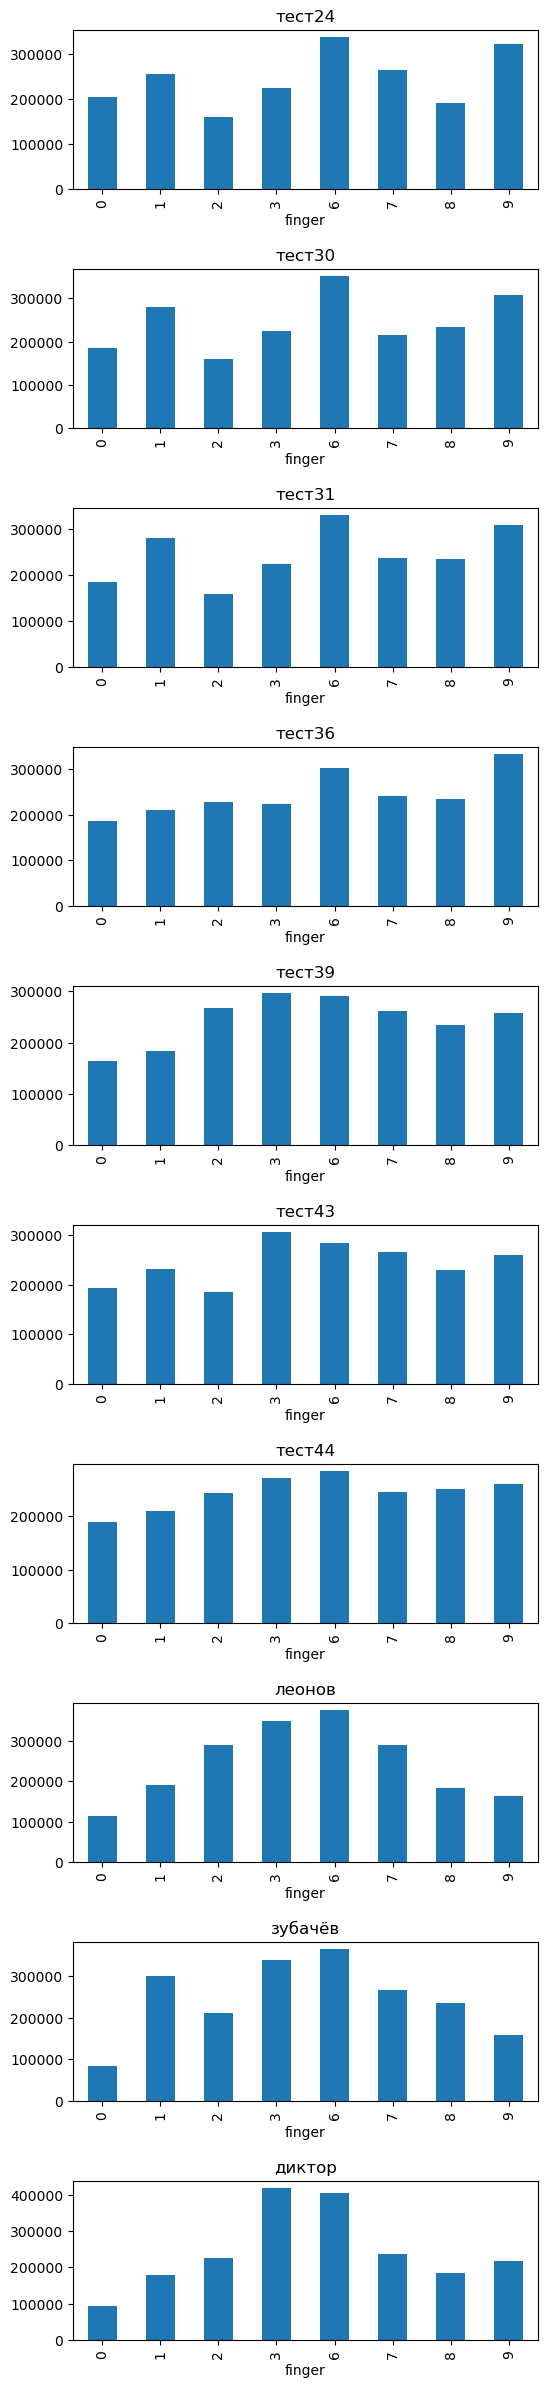

In [17]:
keys = ('тест24', 'тест30', 'тест31', 'тест36', 'тест39', 'тест43', 'тест44', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 3 * len(keys)))
plt.subplots_adjust(hspace=.5)

for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

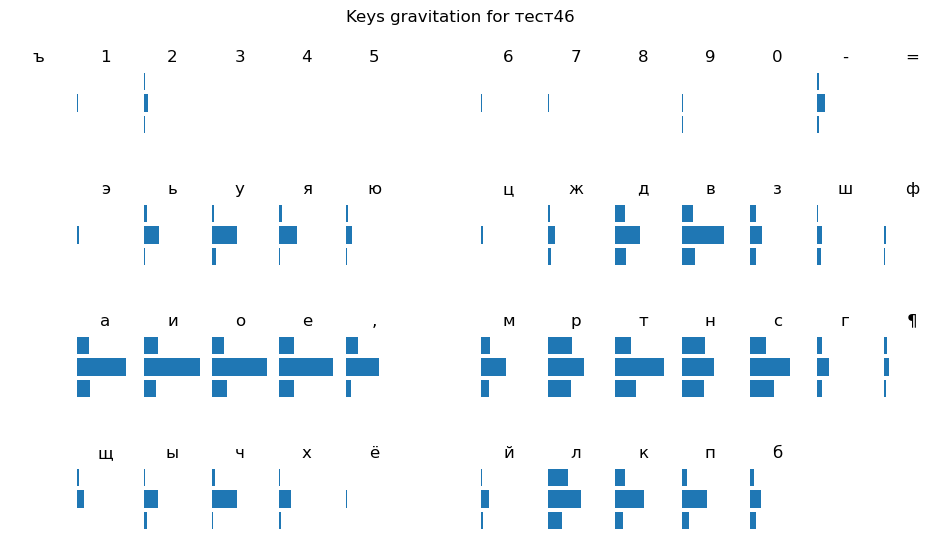

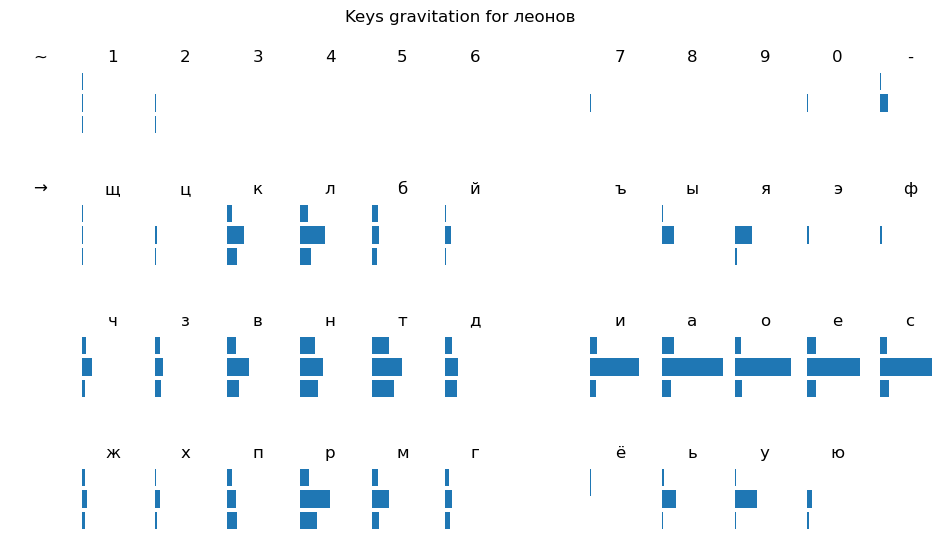

In [18]:
results[key].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [19]:
pos_penalties = STANDARD_KBD.keymap['penalty'].values
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.0

name    row    col    pos  rollout    cost  coord  pareto_opt
0       йцукен  2.709  0.206  1.840    0.173  11.071  3.088       False
1   usphonetic  1.701  0.167  1.676    0.204   7.928  2.072       False
2    rusdvorak  1.248  0.126  1.084    0.181   5.806  1.555       False
3       диктор  1.274  0.109  1.161    0.155   5.822  1.538       False
4      зубачёв  1.229  0.090  1.081    0.152   5.558  1.471       False
5          ант  1.262  0.142  1.419    0.175   6.188  1.579       False
6        ugnvs  1.444  0.158  1.199    0.206   6.672  1.808       False
7       леонов  1.032  0.108  0.939    0.179   4.968  1.319       False
8        тест1  2.319  0.204  1.788    0.183   9.886  2.706       False
18      тест11  1.435  0.157  1.496    0.146   6.700  1.738       False
31      тест24  1.093  0.075  0.991    0.143   4.991  1.311       False
34      тест27  1.056  0.093  1.007    0.145   4.940  1.294       False
37      тест30  1.063  0.094  0.936    0.147   4.900  1.304       False
38      тест31  1.055  0.094  0.927    0.147   4.867  1.296        True
39      тест32  1.054  0.094  0.931    0.155   4.904  1.303       False
44      тест36  1.083  0.091  0.915    0.150   4.947  1.324        True
46      тест38  1.132  0.083  0.920    0.147   5.069  1.362       False
47      тест39  1.134  0.083  0.904    0.146   5.054  1.363        True
48      тест40  1.115  0.079  0.936    0.147   5.025  1.341       False
49      тест41  1.071  0.105  0.967    0.144   4.966  1.320       False
50      тест42  1.076  0.105  0.951    0.144   4.964  1.325       False
51      тест43  1.079  0.106  0.942    0.145   4.971  1.330       False
52      тест44  0.992  0.094  0.941    0.150   4.704  1.236        True

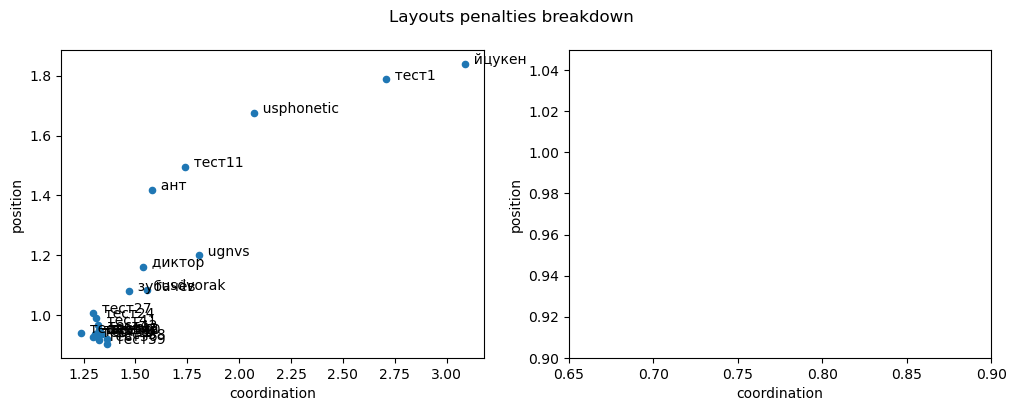

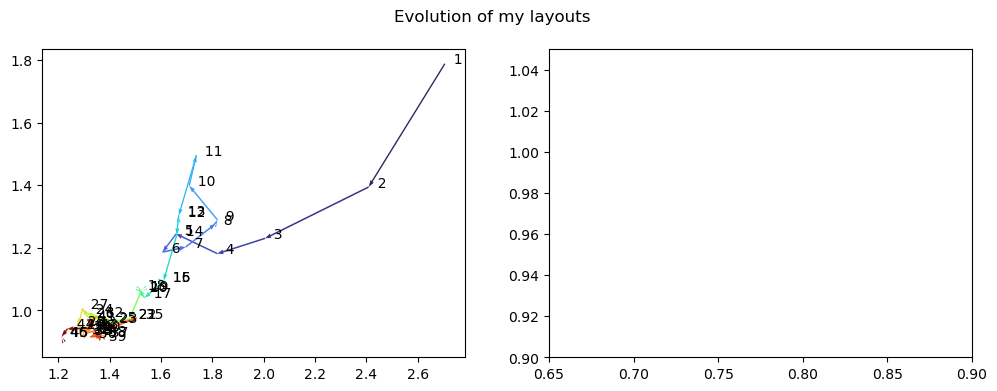

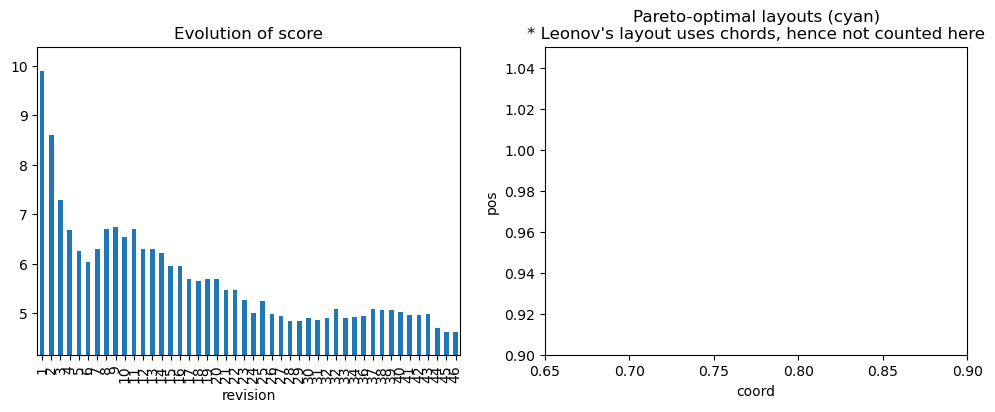

In [20]:
xlims = (.65, .9)
ylims = (.9, 1.05)

dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    bgcost = b.cost
    dd.append({
        'name': k, 
        'row': round((b.row_cost * b.num).sum() / b.num.sum(), 3),
        'col': round((b.col_cost * b.num).sum() / b.num.sum(), 3),
        'pos': round((b.k2penalty * b.num).sum() / b.num.sum(), 3),
        'rollout': round((b.rollout * b.num).sum() / b.num.sum(), 3),
        'cost': round(bgcost.sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)
df2['coord'] = df2['row'] + df2['col'] + df2['rollout']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin([
    'тест44', 'тест43', 'тест42', 'тест41', 'тест40', 'тест39', 'тест38', 'тест36', 'тест32', 'тест31', 'тест30', 'тест27', 'тест24', 'тест1', 'тест11'])].copy()
for ax in (ax1, ax2):
    df3.plot.scatter(x='coord', y='pos', ax=ax)
    for i, rw in df3.iterrows():
        ax.annotate('  ' + str(rw['name']), (rw.coord, rw.pos))

    for a in (ax1, ax2):
        a.set_xlabel('coordination')
        a.set_ylabel('position')

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['coord1'] = df4.coord.diff(-1)
df4['pos1'] = df4.pos.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    a.set_xlabel('coordination')
    a.set_ylabel('position')
    for _, rw in df4.iterrows():
        ax.arrow(
            rw['coord'], rw['pos'], -rw['coord1'], -rw['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(rw.revision / maxnum)
        )
        ax.annotate(f'  {rw["revision"]}', (rw['coord'], rw['pos']))

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = df5['cost']
scores.plot.bar(ax=ax1, title='Evolution of score')
ax1.set_ylim(scores.min() * .9, scores.max() * 1.05)

df3['pareto_opt'] = df3.apply(lambda row: len(df3[(df3.coord < row.coord) & (df3.pos < row.pos) & (df3.name != 'леонов')]) == 0, axis=1)

df3[df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#2288aa', marker='o', ax=ax2)
df3[~df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#ee4444', marker='o', ax=ax2)
for _, rw in df3.iterrows():
    ax2.annotate(f'  {rw["name"]}', (rw['coord'], rw['pos']))

ax2.set_title('Pareto-optimal layouts (cyan)\n* Leonov\'s layout uses chords, hence not counted here')
ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

df3

#### How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are 41, 42, 39 and 32 (if we exclude `леонов` that uses chords). All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

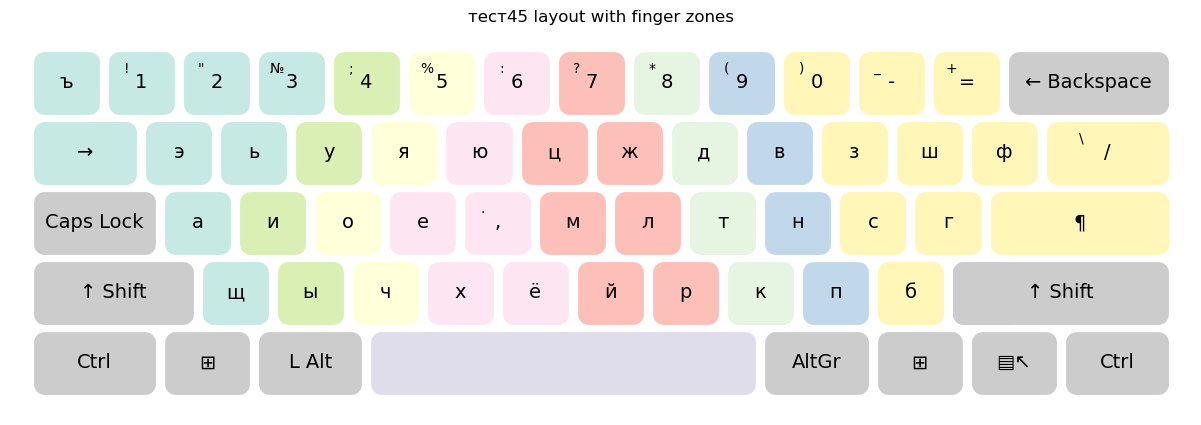

In [21]:
results['тест45'].layout.display()

In [22]:
results['тест45'].layout.export()


default partial alphanumeric_keys
xkb_symbols "тест45" {
	include "ru(common)"
	name[Group1]= "Culebron (тест45)";
	
	key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };


	key <AD01> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD02> { [ Cyrillic_softsign, Cyrillic_SOFTSIGN ] };
	key <AD03> { [ Cyrillic_u, Cyrillic_U ] };
	key <AD04> { [ Cyrillic_ya, Cyrillic_YA ] };
	key <AD05> { [ Cyrillic_yu, Cyrillic_YU ] };
	key <AD06> { [ Cyrillic_tse, Cyrillic_TSE ] };
	key <AD07> { [ Cyrillic_zhe, Cyrillic_ZHE ] };
	key <AD08> { [ Cyrillic_de, Cyrillic_DE ] };
	key <AD09> { [ Cyrillic_ve, Cyrillic_VE

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram    num        row_cat_old  row_cost_old           col_cat_old  \
1203     чо   3656  alternating hands      0.000000  alternating or space   
302      тк   3305                         1.000000                    ok   
100      оч   2870  alternating hands      0.000000  alternating or space   
96       оя   2175                         0.000000                    ok   
143      кт   2685                         1.000000                    ok   
345      вп   1040                         2.000000                    ok   
1133     жл    992                         0.666667                    ok   
1132     мж   1398                         1.200000                    ok   
974      ыи   1332                         2.000000                    ok   
446      дк    871                         2.000000                    ok   
380      лж    931                         0.666667                    ok   
211      рж   1217                         0.800000                    ok   
1368     нп   1103                         1.000000                    ok   
759      пн    843                         1.000000                    ok   
935      оу   3533                         1.000000                    ok   
255      ои   8132                         0.000000                    ok   
906      сб   1273                         1.000000                    ok   
675      зб    580                         0.400000                    ok   
494      рц    382  alternating hands      0.000000  alternating or space   
133      ⌴ч   6117  alternating hands      0.000000  alternating or space   
1020     бз    551                         0.400000                    ok   
1490     ьа    522                         1.000000                    ok   
101      че   4745  alternating hands      0.000000  alternating or space   
25       ⌴м   9387  alternating hands      0.000000  alternating or space   
138      я⌴  12819              thumb      0.000000                    ok   
964      кд    504                         2.000000                    ok   
207      уч   1559  alternating hands      0.000000  alternating or space   
191      ом   7467  alternating hands      0.000000  alternating or space   
233      еч   1965  alternating hands      0.000000  alternating or space   
39       ь⌴  10372              thumb      0.000000                    ok   

      col_cost_old  k2penalty_old  rollout_old  cost_old  \
1203           0.0              0            0       0.0   
302            0.0              1            0   13220.0   
100            0.0              0            0       0.0   
96             0.0              0            0       0.0   
143            0.0              0            1   18795.0   
345            0.0              1            1   11440.0   
1133           2.0              2            0    7936.0   
1132           1.0              4            1   19012.8   
974            1.0              0            0   10656.0   
446            0.0              1            0    6097.0   
380            2.0              4            1   13034.0   
211            1.0              4            1   15090.8   
1368           0.0              1            1    8824.0   
759            0.0              0            0    2529.0   
935            0.0              1            0   14132.0   
255            0.0              0            0       0.0   
906            0.0              2            0    6365.0   
675            1.0              2            0    3016.0   
494           -0.5              2            0     382.0   
133            0.0              0            0       0.0   
1020           1.0              2            1    5069.2   
1490           0.0              0            1    3654.0   
101            0.0              1            0    4745.0   
25             0.0              0            0       0.0   
138            0.0              1            0   12819.0   
964            0.0              1            1    5544.0 

/usr/lib/python3/dist-packages/IPython/core/events.py:82: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


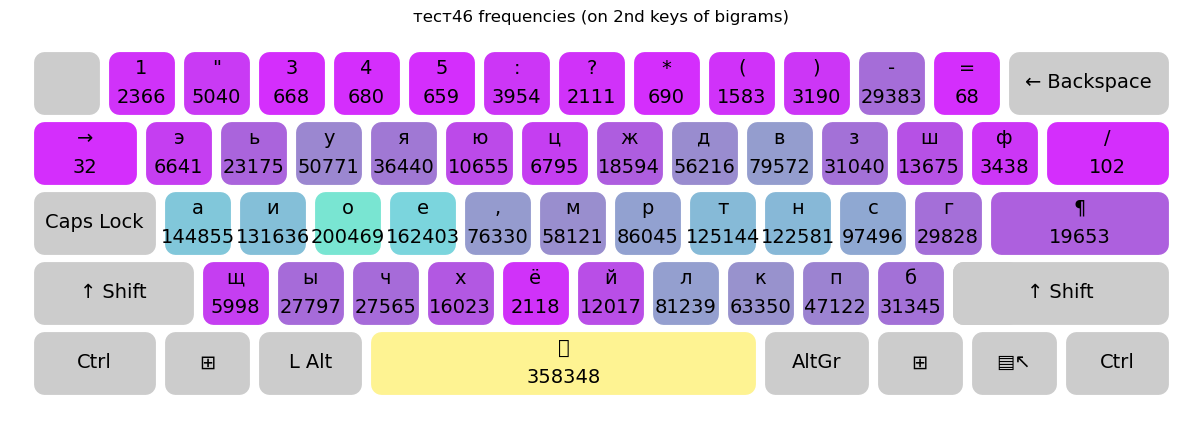

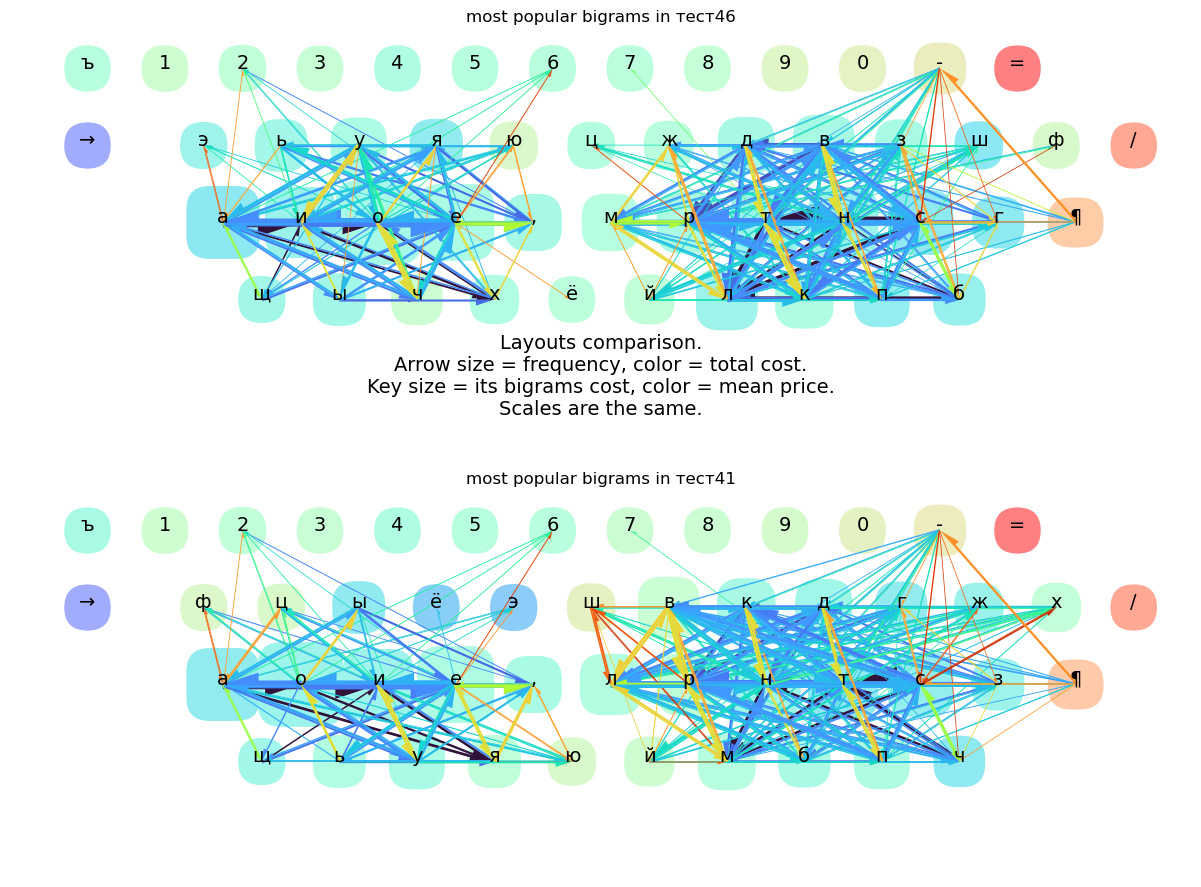

In [23]:
results[key].display('num')
results[key].combomap(results['тест41'])
results['тест43'].compare(results[key]).sort_values('delta', ascending=False).head(30)

## Losses

In [24]:
compare(results, 'тест43', key).head(30)

bigram    num        row_cat_old  row_cost_old           col_cat_old  \
1203     чо   3656  alternating hands      0.000000  alternating or space   
302      тк   3305                         1.000000                    ok   
100      оч   2870  alternating hands      0.000000  alternating or space   
96       оя   2175                         0.000000                    ok   
143      кт   2685                         1.000000                    ok   
345      вп   1040                         2.000000                    ok   
1133     жл    992                         0.666667                    ok   
1132     мж   1398                         1.200000                    ok   
974      ыи   1332                         2.000000                    ok   
446      дк    871                         2.000000                    ok   
380      лж    931                         0.666667                    ok   
211      рж   1217                         0.800000                    ok   
1368     нп   1103                         1.000000                    ok   
759      пн    843                         1.000000                    ok   
935      оу   3533                         1.000000                    ok   
255      ои   8132                         0.000000                    ok   
906      сб   1273                         1.000000                    ok   
675      зб    580                         0.400000                    ok   
494      рц    382  alternating hands      0.000000  alternating or space   
133      ⌴ч   6117  alternating hands      0.000000  alternating or space   
1020     бз    551                         0.400000                    ok   
1490     ьа    522                         1.000000                    ok   
101      че   4745  alternating hands      0.000000  alternating or space   
25       ⌴м   9387  alternating hands      0.000000  alternating or space   
138      я⌴  12819              thumb      0.000000                    ok   
964      кд    504                         2.000000                    ok   
207      уч   1559  alternating hands      0.000000  alternating or space   
191      ом   7467  alternating hands      0.000000  alternating or space   
233      еч   1965  alternating hands      0.000000  alternating or space   
39       ь⌴  10372              thumb      0.000000                    ok   

      col_cost_old  k2penalty_old  rollout_old  cost_old  \
1203           0.0              0            0       0.0   
302            0.0              1            0   13220.0   
100            0.0              0            0       0.0   
96             0.0              0            0       0.0   
143            0.0              0            1   18795.0   
345            0.0              1            1   11440.0   
1133           2.0              2            0    7936.0   
1132           1.0              4            1   19012.8   
974            1.0              0            0   10656.0   
446            0.0              1            0    6097.0   
380            2.0              4            1   13034.0   
211            1.0              4            1   15090.8   
1368           0.0              1            1    8824.0   
759            0.0              0            0    2529.0   
935            0.0              1            0   14132.0   
255            0.0              0            0       0.0   
906            0.0              2            0    6365.0   
675            1.0              2            0    3016.0   
494           -0.5              2            0     382.0   
133            0.0              0            0       0.0   
1020           1.0              2            1    5069.2   
1490           0.0              0            1    3654.0   
101            0.0              1            0    4745.0   
25             0.0              0            0       0.0   
138            0.0              1            0   12819.0   
964            0.0              1            1    5544.0 

## Gains

In [25]:
compare(results, 'тест43', key).tail(30)

bigram   num              row_cat_old  row_cost_old  \
45       ел  8226        alternating hands           0.0   
463      ях   346  same finger change rows          25.0   
523      тл  4613                                    0.5   
88       ол  8682        alternating hands           0.0   
146      рм  2428  same finger change rows          15.0   
111      их  2358                                    2.0   
1591     мш   344  same finger change rows          30.0   
1120     оы  2681                                    4.0   
581      яе   848  same finger change rows          15.0   
626      лб  1016  same finger change rows          15.0   
459      тп  1327  same finger change rows          15.0   
1050     чс  1924  same finger change rows          10.0   
344      я.  1333  same finger change rows          15.0   
348      рб  1615  same finger change rows          15.0   
280      шл   972  same finger change rows          25.0   
718      пт  1667  same finger change rows          15.0   
1407     пд  1367  same finger change rows          20.0   
1375     лш  1112  same finger change rows          25.0   
702      аы  1285  same finger change rows          20.0   
427      рш  1157  same finger change rows          25.0   
453      кв  1611  same finger change rows          20.0   
457      ея  2178  same finger change rows          15.0   
318      бр  1901  same finger change rows          15.0   
441      вк  1611  same finger change rows          20.0   
132      я,  1936  same finger change rows          15.0   
313      кн  2407  same finger change rows          15.0   
1159     ыа  1887  same finger change rows          20.0   
1460     ьо  2828  same finger change rows          15.0   
307      нк  2616  same finger change rows          15.0   
340      бл  3937  same finger change rows          15.0   

               col_cat_old  col_cost_old  k2penalty_old  rollout_old  \
45    alternating or space           0.5              2            0   
463                     ok           1.0              4            0   
523                     ok           1.0              2            0   
88    alternating or space           0.5              2            0   
146                     ok           0.0              0            0   
111                     ok           1.0              4            0   
1591                    ok           1.0              5            0   
1120                    ok           1.0              3            1   
581                     ok           0.0              1            0   
626                     ok           1.0              2            0   
459                     ok           0.0              1            0   
1050                    ok           0.0              0            0   
344                     ok           1.0              2            0   
348                     ok           0.0              2            0   
280                     ok           0.0              2            0   
718                     ok           0.0              0            0   
1407                    ok           0.0              1            0   
1375                    ok           0.0              5            0   
702                     ok           1.0              3            0   
427                     ok           1.0              5            0   
453                     ok           0.0              1            0   
457                     ok           0.0              0            0   
318                     ok           0.0              1            0   
441                     ok           0.0              1            0   
132                     ok           1.0              2            0   
313                     ok           0.0              0            0   
1159                    ok           1.0              0            0   
1460                    ok           0.0              0            0   
307                     ok           0.0              1 

You can save the comparison table to CSV:

In [26]:
compare(results, 'леонов', key).to_csv(f'leonov-{key}.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [27]:
results[key].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  num_tri  row1  column1  ...  \
361      оо  12868  о  о  v  v  0.000260    12555     2        3  ...   
259      ее   7409  е  е  v  v  0.001183     5984     2        4  ...   
125      --   5989  -  -  -  -  0.004756      258     0       12  ...   
29       ии   6222  и  и  v  v  0.000996     5022     2        2  ...   
186      вн   3723  в  н  c  c  0.001205     2271     1       10  ...   
1386     чо   3656  ч  о  c  v  0.000109     3525     3        3  ...   
1873     аа   5124  а  а  v  v  0.000006     5117     2        1  ...   
302      тк   3305  т  к  c  c  0.000520     2679     2        9  ...   
89       ⌴о  37974  ⌴  о  -  v  0.008205    28087     4        0  ...   
270      е,   4322  е  ,  v  -  0.001896     2037     2        4  ...   
773      ¶-   2144  ¶  -  -  -  0.000892     1069     2       13  ...   
352      нн   4484  н  н  c  c  0.002824     1081     2       10  ...   
100      оч   2870  о  ч  v  c  0.001572      976     2        3  ...   
240      ⌴е  24576  ⌴  е  -  v  0.002581    21466     4        0  ...   
143      кт   2685  к  т  c  c  0.001040     1432     3        9  ...   
770      дт   2630  д  т  c  c  0.000130     2473     1        9  ...   
1186     уи   2514  у  и  v  v  0.000017     2493     1        3  ...   
594      ..   3676  .  .  -  -  0.001938     1341     2        5  ...   
53       ¶¶   3372  ¶  ¶  -  -  0.002493      368     2       13  ...   
898      иу   2222  и  у  v  v  0.000032     2183     2        2  ...   
96       оя   2175  о  я  v  v  0.000590     1464     2        3  ...   
266      ⌴а  25525  ⌴  а  -  v  0.002022    23089     4        0  ...   
796      нв   2141  н  в  c  c  0.000056     2073     2       10  ...   
359      е.   2518  е  .  v  -  0.001022     1286     2        4  ...   
765      мл   1770  м  л  c  c  0.000227     1496     2        7  ...   
146      рм   2428  р  м  c  c  0.000333     2027     2        8  ...   
23       ⌴и  18838  ⌴  и  -  v  0.009774     7061     4        0  ...   
1685     кк   2338  к  к  c  c  0.000018     2316     3        9  ...   
1297     мж   1398  м  ж  c  c  0.000005     1392     2        7  ...   
561      тт   2196  т  т  c  c  0.000093     2084     2        9  ...   

      rollout  k2penalty  row column  finger ftype  hand  penalty  reach  \
361         0          0    2      3       2     2     0        0      1   
259         0          1    2      4       3     1     0        0      2   
125         0          5    0     12       9     4     1        0      5   
29          0          0    2      2       1     3     0        0      1   
186         0          0    2     10       8     3     1        0      1   
1386        0          0    2      3       2     2     0        0      1   
1873        0          0    2      1       0     4     0        0      1   
302         0          1    3      9       7     2     1        0      0   
89          1          0    2      3       2     2     0        0      1   
270         0          2    2      5       3     1     0        0      2   
773         0          5    0     12       9     4     1        0      5   
352         0          0    2     10       8     3     1        0      1   
100         0          1    3      3       2     2     0        0      0   
240         1          1    2      4       3     1     0        0      2   
143         0          0    2      9       7     2     1        0      1   
770         0          0    2      9       7     2     1        0      1   
1186        0          0    2      2       1     3     0        0      1   
594         0          2    2      5       3     1     0        0      2   
53          0          4    2     13       9     4     1        0      3   
898         0          2    1      3       1     3     0        0      2   
96          0          2    1      4       2     2     0        0      2   
266         1          0    2      1       0     4     0        0    

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [28]:
res = results[key]

keys_df = (res.layout.keymap[['row', 'column']]
 .reset_index()
 .merge(res.layout.keyboard.keymap, on=['row', 'column'])
).set_index('index')


b1 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_self', '_other')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_self', 'column_self', 'row_other', 'column_other'], right_index=True
    )
b1['kind'] = 'forward'
b1.rename(columns={'l1': 'self', 'l2': 'other', 'hand2': 'hand_other', 'hand1': 'hand_self',
                   't1': 'type_self', 't2': 'type_other'}, inplace=True)

b2 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_other', '_self')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_other', 'column_other', 'row_self', 'column_self'], right_index=True
    )
b2['kind'] = 'backward'
b2.rename(columns={'l2': 'self', 'l1': 'other', 'hand1': 'hand_other', 'hand2': 'hand_self',
                  't2': 'type_self', 't1': 'type_other'}, inplace=True)

pd.concat([b1, b2]).to_csv(f'all-letters-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [29]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count
ъ      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
э      0    1       1          1
ь      0    1       2          1
у      0    1       3          1
я      0    1       4          1
ю      0    1       5          1
ц      0    1       7          1
ж      0    1       8          1
д      0    1       9          1
в      0    1      10          1
з      0    1      11          1
ш      0    1      12          1
ф      0    1      13          1
/      0    1      14          1
а      0    2       1          1
и      0    2       2          1
о      0    2       3          1
е      0    2       4          1
,      0    2       5          1
м      0    2       7          1
р      0    2       8          1
т      0    2       9          1
н      0    2      10          1
с      0    2      11          1
г      0    2      12          1
¶      0    2      13          1
щ      0    3       1          1
ы      0    3       2          1
ч      0    3       3          1
х      0    3       4          1
ё      0    3       5          1
й      0    3       7          1
л      0    3       8          1
к      0    3       9          1
п      0    3      10          1
б      0    3      11          1
⌴      0    4       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
\      1    1      14          1
.      1    2       5          1

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor with modified punctuation marks, and is omitted.

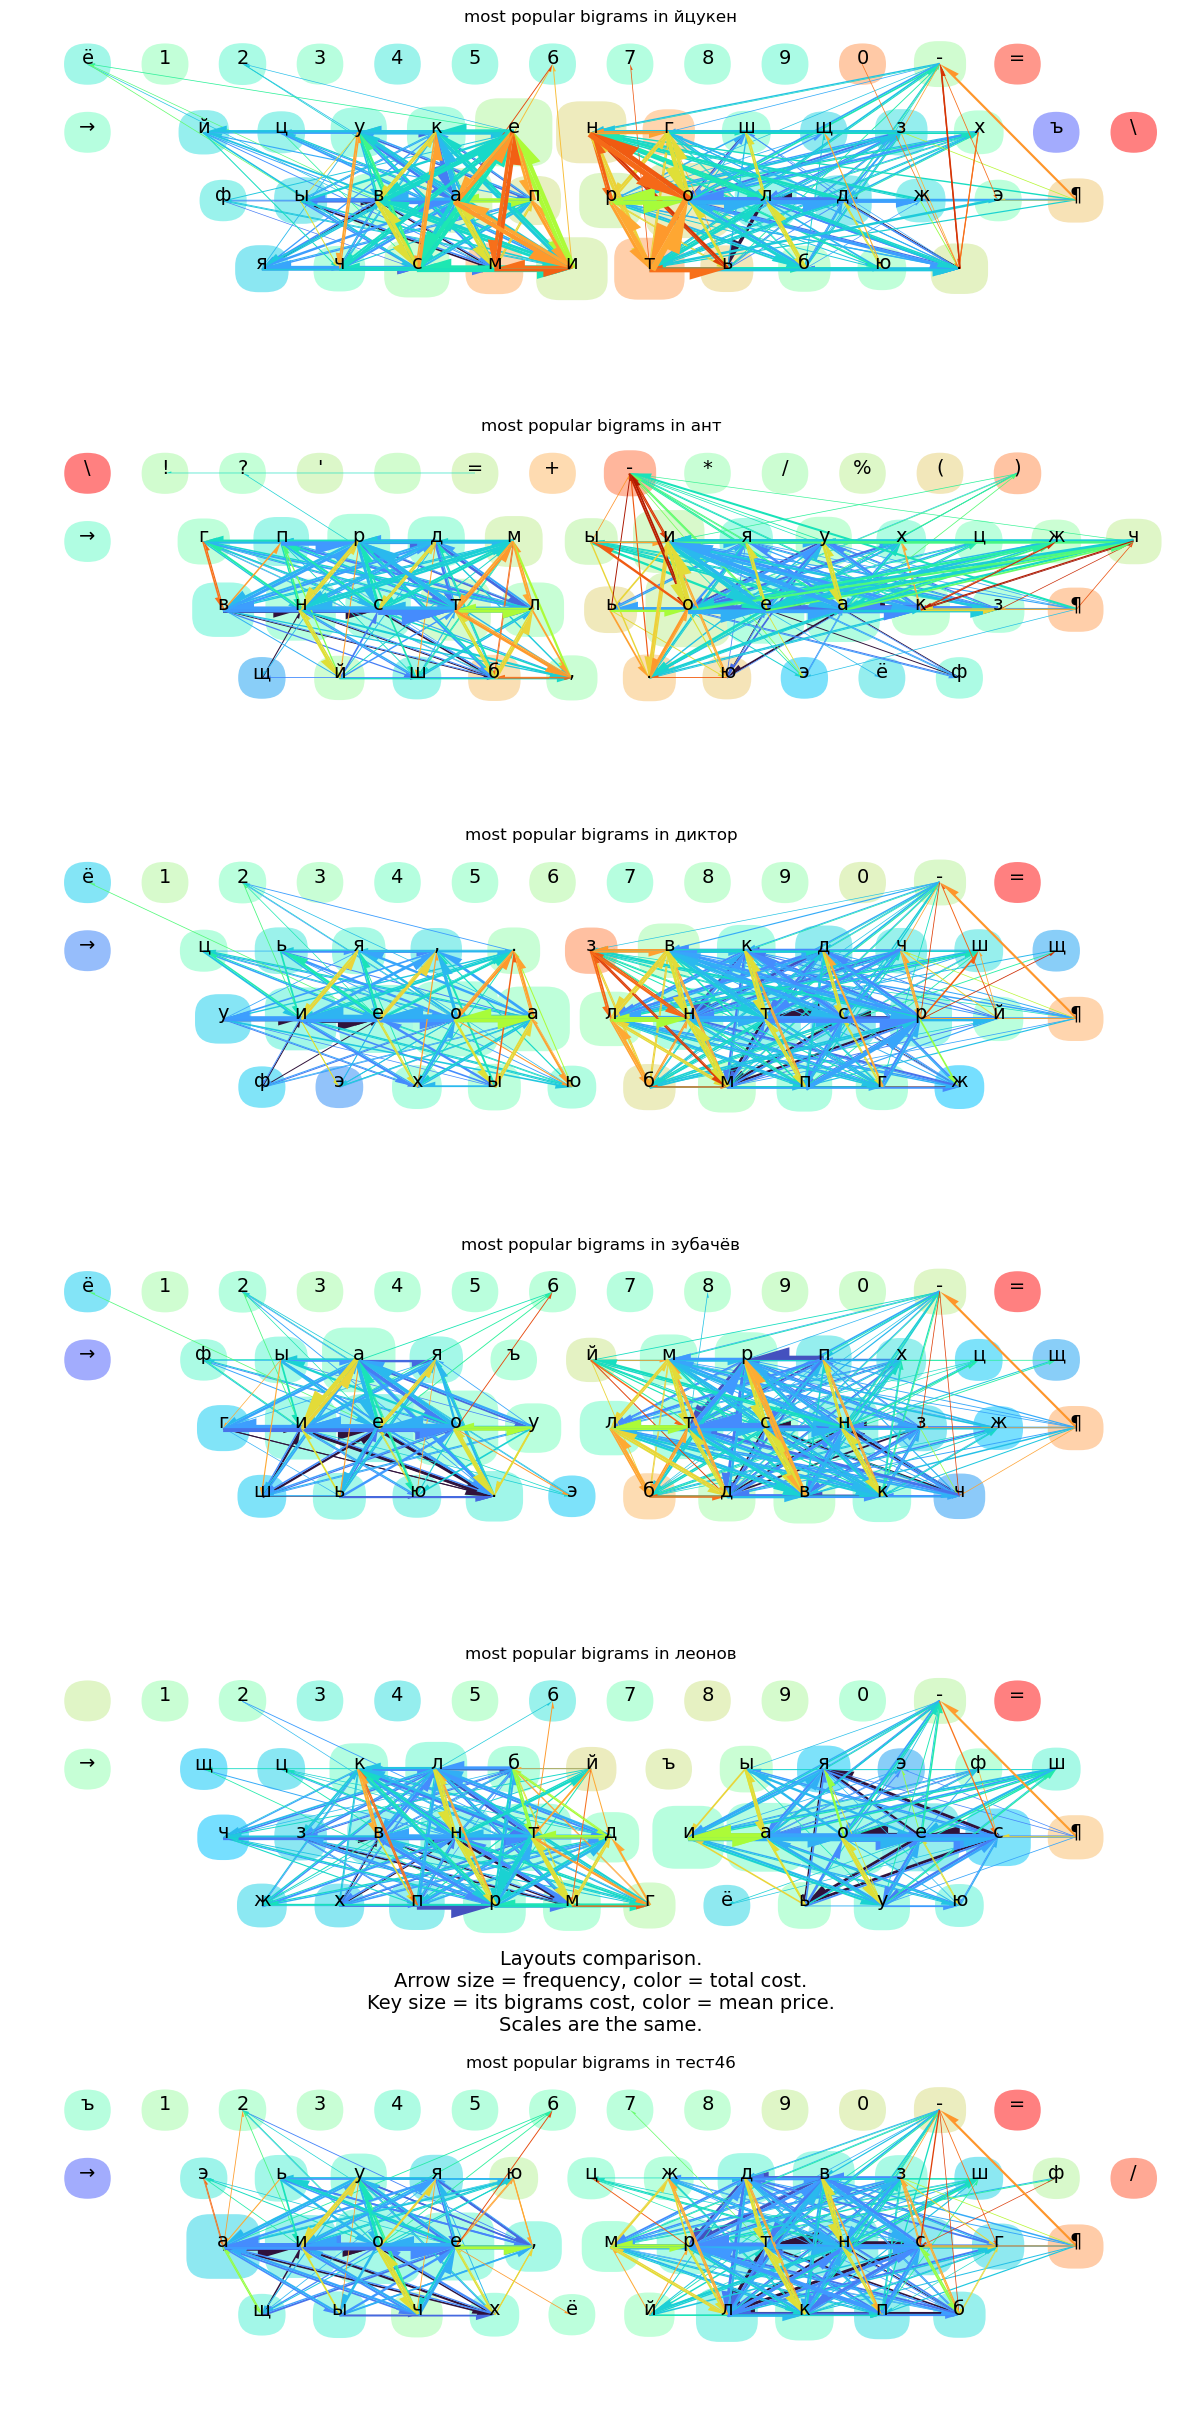

In [30]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs[key])

# Heatmaps <a name="heatmaps">


/usr/lib/python3/dist-packages/IPython/core/events.py:82: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)


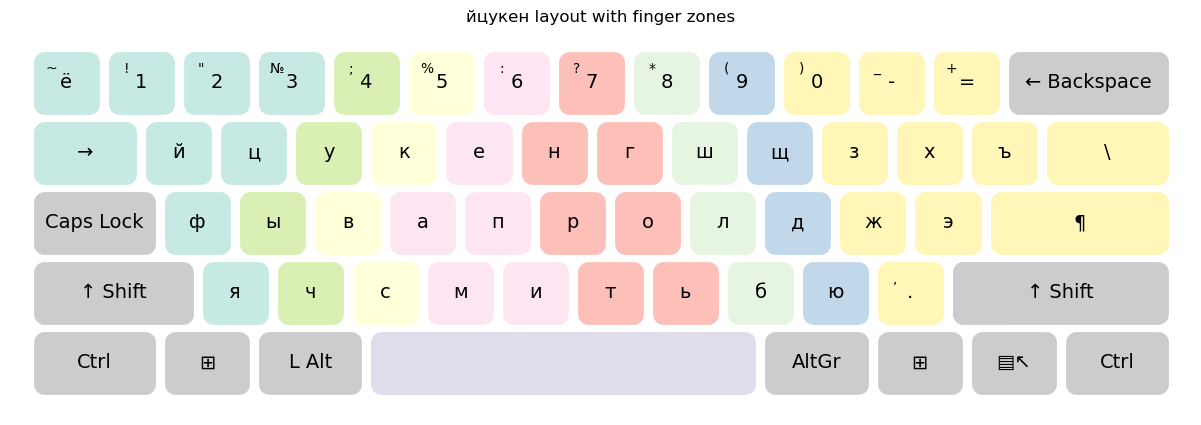

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


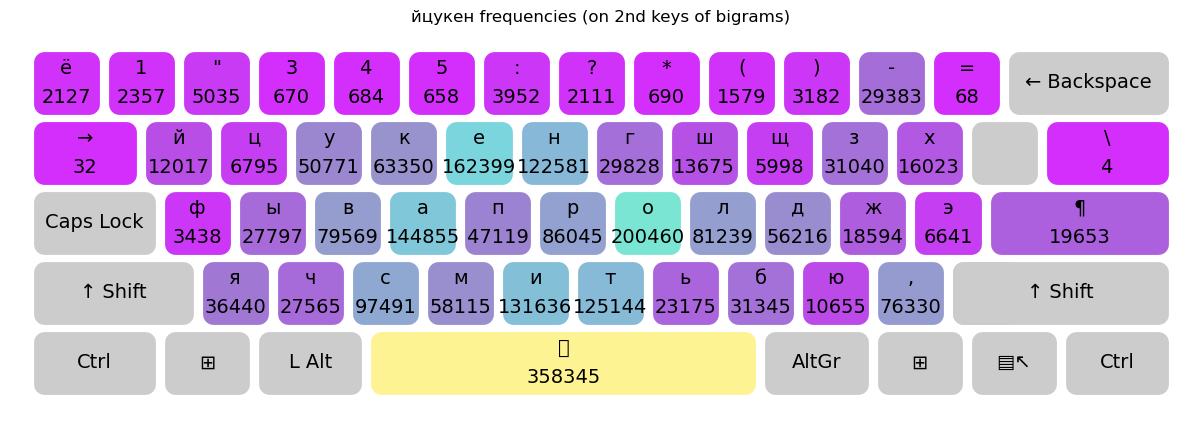

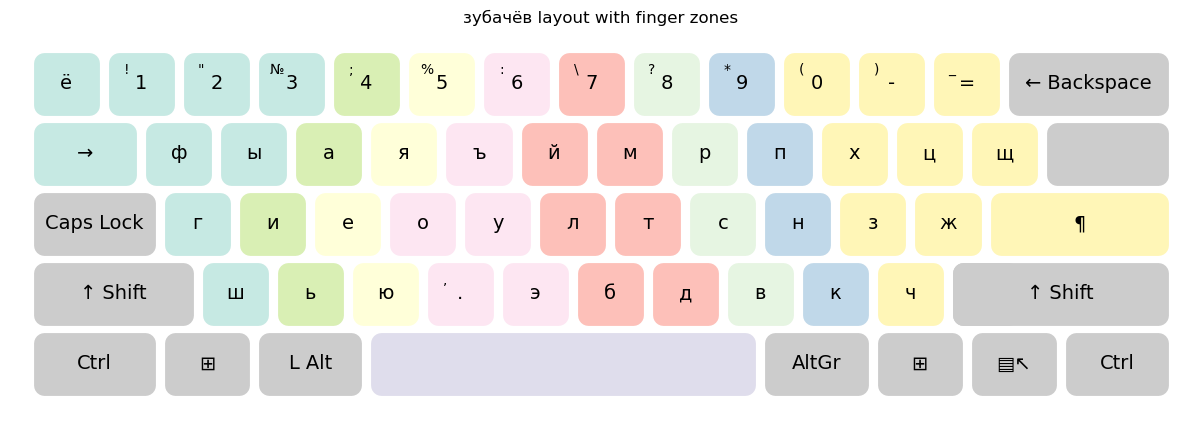

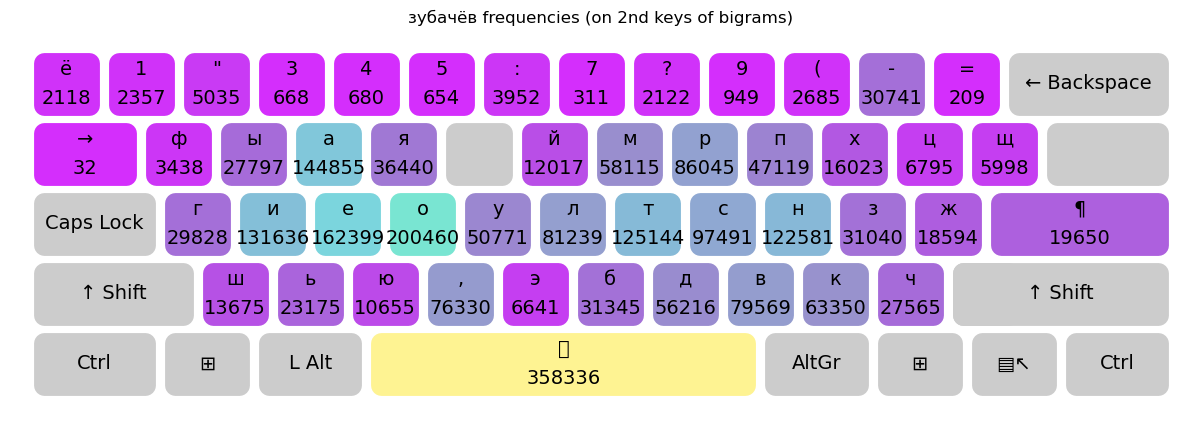

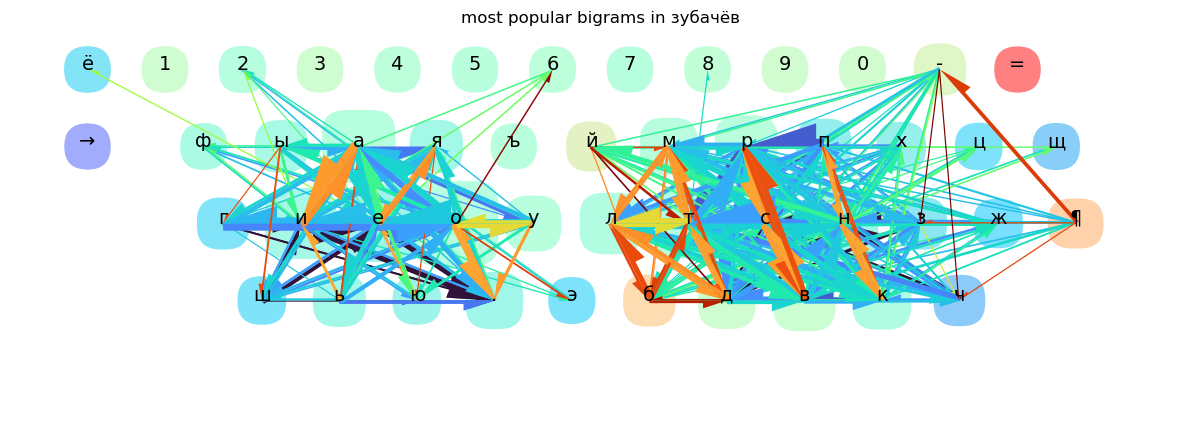

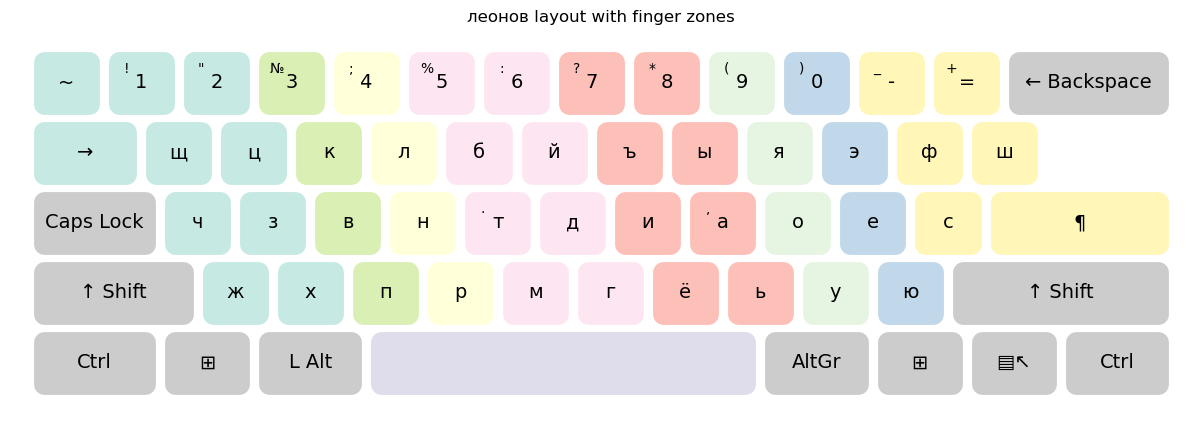

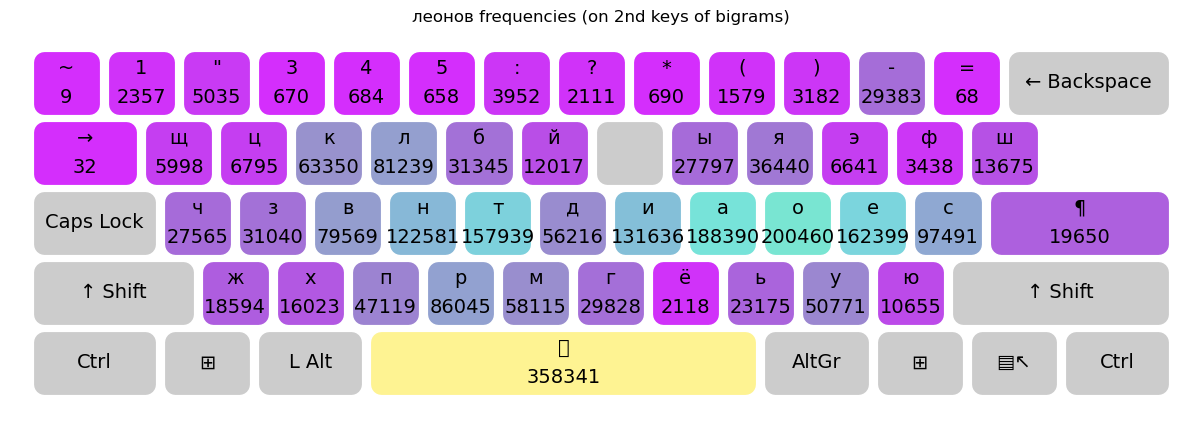

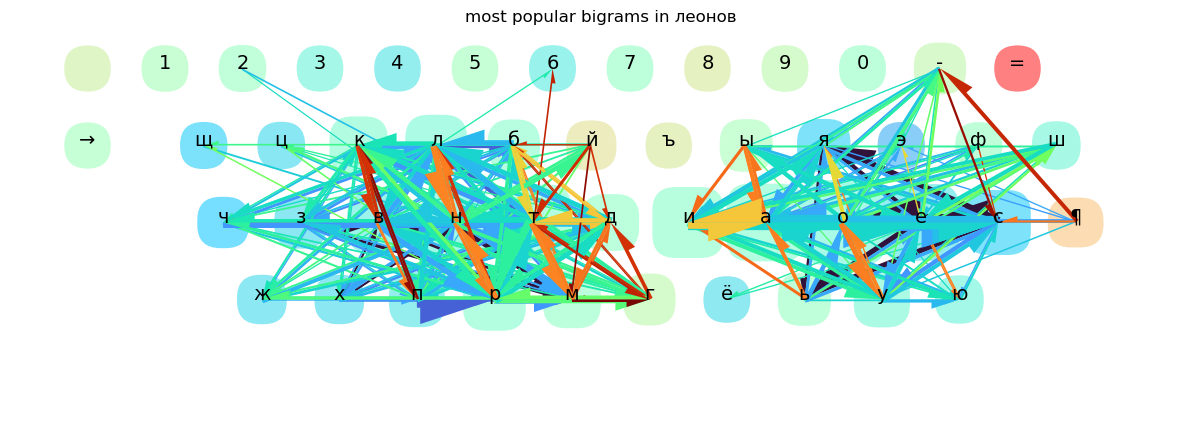

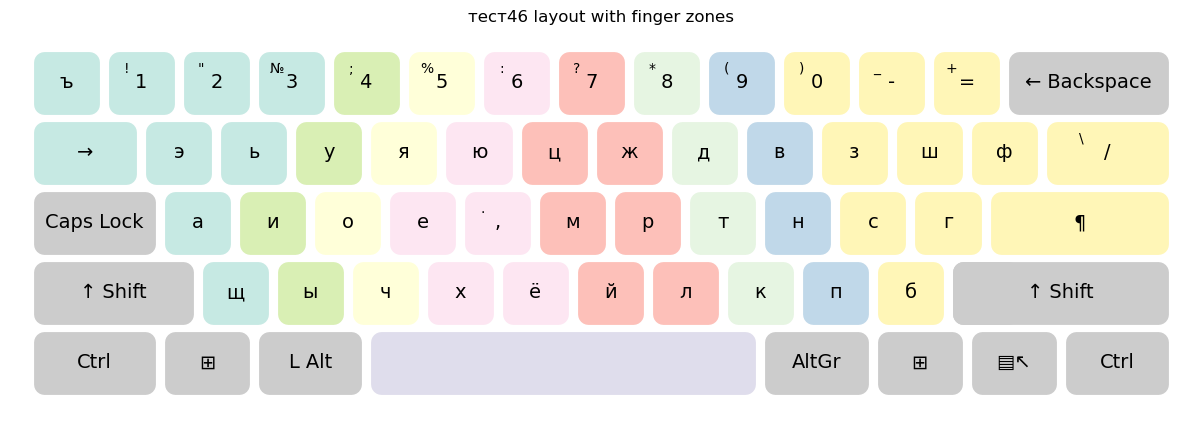

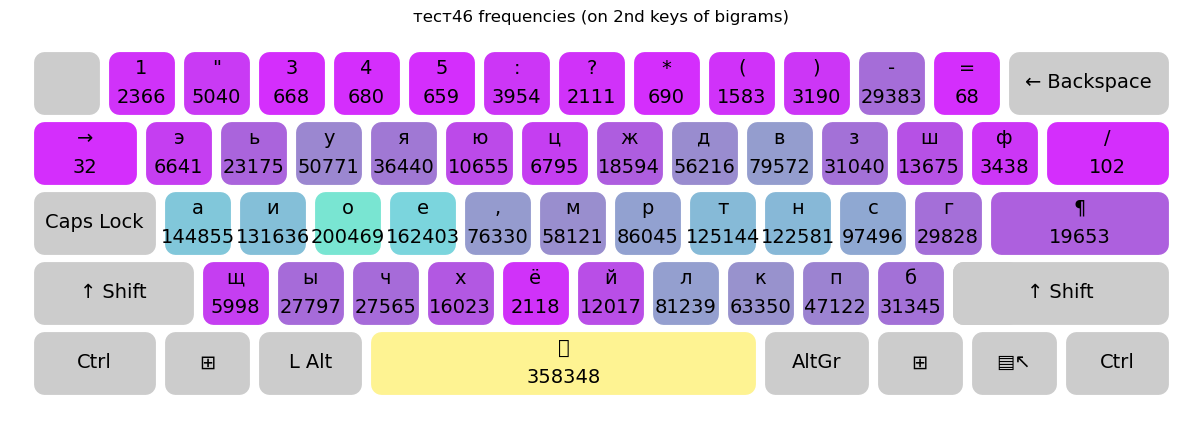

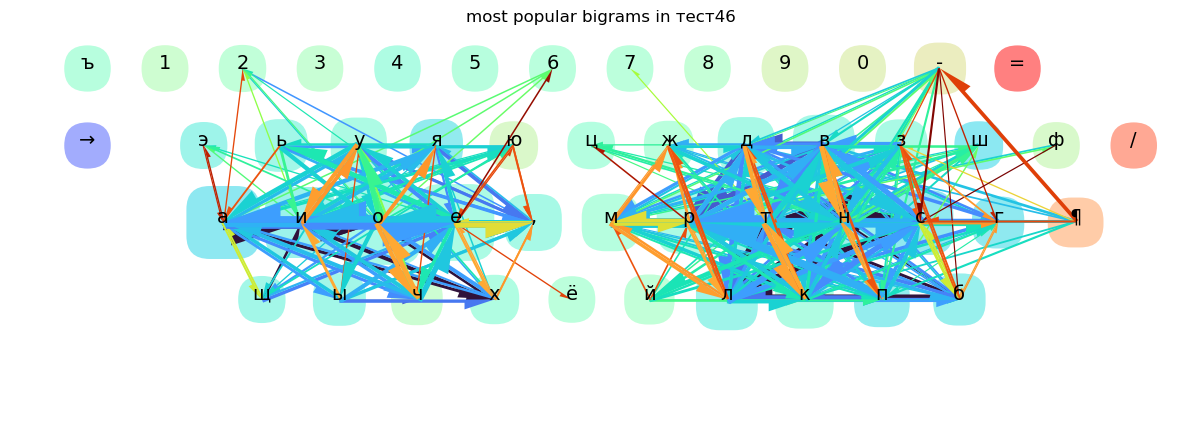

In [31]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results[key].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [32]:
cmp = compare(results, 'леонов', key)
cmp.head(30)

bigram    num              row_cat_old  row_cost_old  \
186      вн   3723                               0.000000   
1192     чо   3656        alternating hands      0.000000   
89       ⌴о  37974        alternating hands      0.000000   
270      е,   4322                               0.666667   
302      тк   3305                               0.666667   
100      оч   2870        alternating hands      0.000000   
240      ⌴е  24576        alternating hands      0.000000   
143      кт   2685                               0.666667   
1061     уи   2514                               1.333333   
760      нв   2141                               0.000000   
862      иу   2222                               1.333333   
359      е.   2518        alternating hands      0.000000   
266      ⌴а  25525        alternating hands      0.000000   
146      рм   2428                               1.000000   
729      мл   1770                               1.000000   
1124     жл    992                               0.500000   
1123     мж   1398                               0.800000   
380      лж    931                               0.500000   
900      ео   6444                               0.000000   
445      дк    871                               0.500000   
75       ,⌴  21945        alternating hands      0.000000   
502      мр   1741                               1.000000   
141      ех    961        alternating hands      0.000000   
1351     нп   1103                               1.000000   
96       оя   2175  same finger change rows     10.000000   
1578     еь   3735                               0.000000   
1157     лм    893                               1.000000   
211      рж   1217                               1.500000   
86       ⌴у   9875        alternating hands      0.000000   
41       пр   9307                               0.000000   

               col_cat_old  col_cost_old  k2penalty_old  rollout_old  \
186                     ok           0.0              0            0   
1192  alternating or space           0.0              0            0   
89    alternating or space           0.0              0            0   
270                     ok           0.0              1            0   
302                     ok           0.0              2            1   
100   alternating or space           0.5              2            0   
240   alternating or space           0.0              0            0   
143                     ok           0.0              1            0   
1061                    ok           1.0              2            0   
760                     ok           0.0              0            1   
862                     ok           1.0              1            1   
359   alternating or space           0.0              1            0   
266   alternating or space           0.0              1            0   
146                     ok           0.0              0            0   
729                     ok           0.0              1            1   
1124                    ok           1.0              1            0   
1123                    ok           1.0              3            1   
380                     ok           1.0              3            1   
900                     ok           0.0              0            0   
445                     ok           1.0              2            1   
75    alternating or space           0.0              1            0   
502                     ok           0.0              1            1   
141   alternating or space           0.0              0            0   
1351                    ok           0.0              1            1   
96                      ok           0.0              0            0   
1578                    ok           0.0              0            0   
1157                    ok           0.0              0            0   
211                     ok           1.0              3            1   
86    alternating or spac

In [33]:
cmp.tail(30)

bigram    num              row_cat_old  row_cost_old  \
1310     тг    999  same finger change rows          20.0   
30       ⌴к  11358                    thumb           0.0   
18       ⌴в  19489                    thumb           0.0   
78       тр   8374                                    2.0   
416      м.   1309  same finger change rows          15.0   
1089     пк    796  same finger change rows          25.0   
1286     мт   1624  same finger change rows          15.0   
206      ы,   1586  same finger change rows          15.0   
695      мг    880  same finger change rows          25.0   
1340     уо   1702  same finger change rows          15.0   
148      т.   2146  same finger change rows          10.0   
9        ⌴р  16163                    thumb           0.0   
1049     дм   1679  same finger change rows          15.0   
40       ⌴п  18344                    thumb           0.0   
1150     ыа   1887  same finger change rows          15.0   
241      ь,   1813  same finger change rows          15.0   
452      кв   1611  same finger change rows          20.0   
1098     нл   1785  same finger change rows          15.0   
66       ⌴н  21727                    thumb           0.0   
440      вк   1611  same finger change rows          20.0   
190      а,   3476  same finger change rows          10.0   
76       ⌴т  18642                    thumb           0.0   
296      гд   1824  same finger change rows          20.0   
295      и,   4016  same finger change rows          10.0   
776      тм   2868  same finger change rows          15.0   
934      оу   3533  same finger change rows          15.0   
339      рн   3364  same finger change rows          15.0   
264      иа   5571  same finger change rows          10.0   
350      лн   5036  same finger change rows          15.0   
771      аи   9143  same finger change rows          10.0   

               col_cat_old  col_cost_old  k2penalty_old  rollout_old  \
1310                    ok           1.0              4            0   
30    alternating or space           0.0              2            1   
18    alternating or space           0.0              0            1   
78                      ok           0.0              1            1   
416                     ok           0.0              1            0   
1089                    ok           0.0              2            0   
1286                    ok           0.0              1            0   
206                     ok           0.0              1            0   
695                     ok           1.0              4            0   
1340                    ok           0.0              0            0   
148                     ok           0.0              1            0   
9     alternating or space           0.0              1            1   
1049                    ok           1.0              0            0   
40    alternating or space           0.0              1            1   
1150                    ok           0.0              1            0   
241                     ok           0.0              1            0   
452                     ok           0.0              0            0   
1098                    ok           0.0              1            0   
66    alternating or space           0.0              0            1   
440                     ok           0.0              2            0   
190                     ok           0.0              1            0   
76    alternating or space           0.0              1            1   
296                     ok           0.0              2            0   
295                     ok           1.0              1            0   
776                     ok           0.0              0            0   
934                     ok           0.0              1            0   
339                     ok           0.0              0            0   
264                     ok           1.0              1            0   
350                     o